In [204]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys, os, cv2, glob, time, random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from torchvision.transforms import Normalize, RandomHorizontalFlip, ToTensor, ToPILImage, Compose, Resize
from sklearn.metrics import log_loss
import pathlib
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

from utils.engine import FastDataset, show, FullVideoReader, VideoDataset
import settings

In [47]:
import skvideo
from skvideo.io import FFmpegReader
reader = skvideo.io.FFmpegReader(fake_fn, outputdict={'-vf':"select=eq(pict_type\,I)"})
frames = []
for frame in reader.nextFrame():
    frames.append(frame)
print(len(frames))

213


In [13]:
import os
import cv2
import subprocess

def get_frame_types(video_fn):
    command = 'ffprobe -v error -show_entries frame=pict_type -of default=noprint_wrappers=1'.split()
    out = subprocess.check_output(command + [video_fn]).decode()
    frame_types = out.replace('pict_type=','').split()
    return zip(range(len(frame_types)), frame_types)

def save_i_keyframes(video_fn):
    frame_types = get_frame_types(video_fn)
    i_frames = [x[0] for x in frame_types if x[1]=='I']
    frames = []
    if i_frames:
        basename = os.path.splitext(os.path.basename(video_fn))[0]
        cap = cv2.VideoCapture(video_fn)
        for frame_no in i_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
            ret, frame = cap.read()
            outname = basename+'_i_frame_'+str(frame_no)+'.jpg'
            frames.append(frame)
#             cv2.imwrite(outname, frame)
#             print ('Saved: '+outname)
        cap.release()
    else:
        print ('No I-frames in '+video_fn)
    
    return frames

i_frames = [x[0] for x in get_frame_types(fake_fn) if x[1]=='P' or x[1]=='I']

In [14]:
len(i_frames)

77

In [64]:
base = '/data1/data/deepfake/dfdc_train/'
metadata = pd.read_json(base + 'metadata_kailu_460.json').T


In [65]:
fn = 'pqthmvwonf.mp4'

In [93]:
fake_fn = fn
real_fn = metadata.loc[fake_fn, 'original']
real_fn = "/data/deepfake/video/" + real_fn.split(".")[0] +"/0/0.png"
fake_fn = "/data/deepfake/video/" + fake_fn.split(".")[0] +"/0/0.png"
# loader = VideoDataset([fake_fn], sample_rate = 300, video_reader=FullVideoReader())
loader = VideoDataset([real_fn, fake_fn], sample_rate = 13, video_reader=FullVideoReader())

In [94]:
def trans(img):
    return np.array(Image.fromarray(img))
    
real_frames = [trans(img) for img in loader[0]]
fake_frames = [trans(img) for img in loader[1]]
# fake_frames = [trans(img) for img in loader[0]]

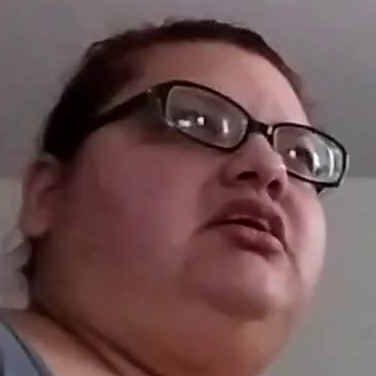

In [107]:
Image.fromarray(real_frames[0])

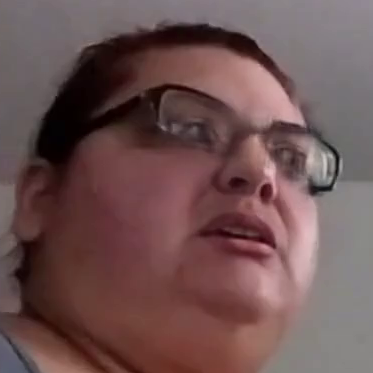

In [109]:
Image.fromarray(fake_frames[1])

In [97]:
def acc_diff(f1, f2, threhold = 30):
    assert f1.shape == f2.shape and len(f1.shape) == 3
    f1 = f1.astype(np.float)
    f2 = f2.astype(np.float)
    ret = np.sum(np.abs(f1-f2), 2) 
    ret[ret<threhold] = 0
    ret[ret>0] = 1
    ret.astype(np.uint8)
    return ret

In [108]:
show([acc_diff(real_frames[i], fake_frames[i]) for i in range(1)])

AssertionError: 

In [115]:
# image()
acc_diff(real_frames[0], fake_frames[0])

(373, 373, 3)

In [238]:
def blur(ret):
    return (ret*9 + np.roll(ret, 1, axis=0)*4 + np.roll(ret, -1, axis=0)*4 + np.roll(ret, 1, axis=1)*4 + np.roll(ret, -1, axis=-1)*4)/25

def get_diff(f1, f2, threhold = 18):
    assert f1.shape == f2.shape and len(f1.shape) == 3
    f1 = f1.astype(np.float)
    f2 = f2.astype(np.float)
    ret = np.sum(np.abs(f1-f2), 2) 
    
    ret = blur(ret)
    ret = blur(ret)
    ret = blur(ret)
    ret = blur(ret)
    
    ret[ret<threhold] = 0
    ret[ret>0] = 1
    
    ret.astype(np.uint8)
    return ret

# def blur(ret: Tensor):
#     return (ret + ret.roll(1, 1) + ret.roll(-1, 1) + ret.roll(1, 2) + ret.roll(-1, 2))/5

# def gen_mask(f1: Tensor, f2: Tensor, threhold=0.07):  # for batch
#     assert f1.shape == f2.shape and len(f1.shape) == 4
#     ret, _ = (f1-f2).abs().max(dim=1)

#     ret = blur(ret)
#     ret = blur(ret)
#     ret = blur(ret)

#     ret[ret < threhold] = 0
#     ret[ret > 0] = 1
#     return ret.long()

In [239]:
diff = np.array([get_diff(f1, f2, threhold=22) for f1,f2 in zip(real_frames, fake_frames)])

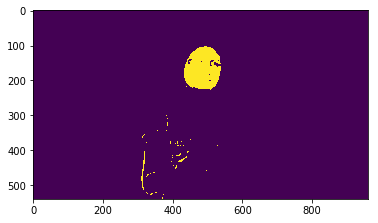

In [248]:
show(diff[-1:])

In [205]:
from model2.data_loader import create_dataloaders
from model2.utils import Unnormalize
from torchvision.transforms import Normalize
from model2.data_loader import training_mean, training_std

In [139]:
norm = Normalize(training_mean, training_std)
unnorm = Unnormalize(training_mean, training_std)

In [101]:
params = {'batch_size': 24, 'n_epochs': 20, 'weight_decay': 1e-05, 'max_lr': 0.0003, 'use_lr_scheduler': 0, 'scheduler_gamma': 0.96, 'dropout': 0.5, 'use_hidden_layer': 0, 'backbone': 1, 'same_transform': 0, 'RandomAffine': 1, 'ColorJitter': 0, 'RandomPerspective': 0, 'RandomErasing': 2, 'data_path': '/data1/data/deepfake/dfdc_train', 'metadata_path': 0, 'cache_path': '/data/deepfake/shots/', 'seed': 1585089327}
params

In [102]:
params['metadata_path'] = settings.meta_data_path[params['metadata_path']]

In [211]:
train_dl, val_dl, test_dl = create_dataloaders(params)

data: 18663
data: 429
data: 59


In [225]:
# visual_iter = iter(val_dl)
inputs, labels, data = next(visual_iter)

In [226]:
print(inputs.shape)
inputs = unnorm(inputs)
inputs = inputs.permute((0,2,3,1))
labels = labels.permute((0,2,3,1)).squeeze()
inputs.shape

torch.Size([42, 3, 512, 960])


torch.Size([42, 512, 960, 3])

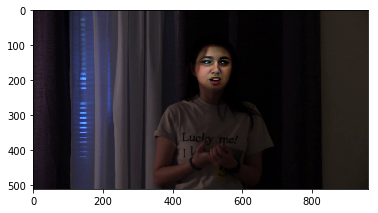

In [228]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(inputs[10])
plt.show()

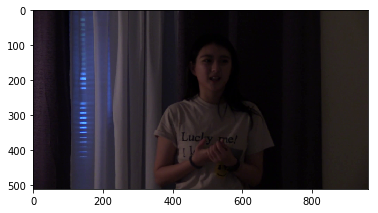

In [229]:
plt.imshow(inputs[31])
plt.show()

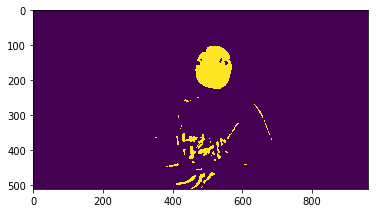

In [231]:
from utils.engine import show
show([labels[10]])

In [177]:
inputs, labels, data = next(visual_iter)

In [201]:
def blur(ret):
    return (ret*9 + ret.roll(1, 2)*4 + ret.roll(-1, 2)*4 + ret.roll(1, 3)*4 + ret.roll(-1, 3)*4) / 25


def gen_mask(f1, f2, threhold=0.1):  # for batch
    assert f1.shape == f2.shape and len(f1.shape) == 4
    ret = (f1 - f2).abs().sum(dim=3, keepdim=True)
    print(ret.mean())

    for i in range(12):
        ret = blur(ret)
        
    ret[ret < threhold] = 0
    ret[ret > 0] = 1
    return ret

tensor(0.0149)
torch.Size([23, 512, 960])


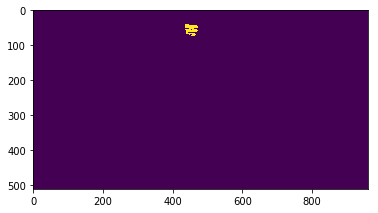

In [202]:
mask = gen_mask(inputs[:23], inputs[23:], threhold=0.0894).squeeze()
print(mask.shape)
plt.imshow(mask[0])
plt.show()

In [190]:
0.0149*6

0.08940000000000001

In [232]:
data['fake_file'][10], data['real_file'][10]

(PosixPath('/data/deepfake/shots/cgdrbrnhma/25.png'),
 PosixPath('/data/deepfake/shots/aerzetktyh/25.png'))

In [52]:
def _random_frames(all_frames):
    num_frames = len(all_frames)
    num_segments = 8
    new_length = 1
    average_duration = (num_frames - new_length + 1) // num_segments
    if average_duration > 0:
        offsets = np.multiply(list(range(num_segments)), average_duration) + np.random.randint(average_duration, size=num_segments)
    elif num_frames > num_segments:
        offsets = np.sort(randint(num_frames - new_length + 1, size=num_segments))
    else:
        offsets = np.zeros((num_segments,))
    return offsets

In [56]:
_random_frames(range(7))

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [60]:
shape = 12
torch.cat([torch.ones((shape, 1)), torch.zeros((shape, 1))], 0).shape

torch.Size([24, 1])